In [ ]:
!git clone https://github.com/KairoSagewing5/DeepLearning2023.git

Cloning into 'DeepLearning2023'...
remote: Enumerating objects: 44982, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 44982 (delta 2), reused 8 (delta 2), pack-reused 44973
Receiving objects: 100% (44982/44982), 1.64 GiB | 13.68 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (44967/44967), done.


In [ ]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)


In [ ]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 78.2 MB/s eta 0:00:00


In [ ]:
categories = {0: 'CARGO_PLANE', 1: 'HELICOPTER', 2: 'SMALL_CAR', 3: 'BUS', 4: 'TRUCK', 5: 'MOTORBOAT', 6: 'FISHING_VESSEL', 7: 'DUMP_TRUCK', 8: 'EXCAVATOR', 9: 'BUILDING', 10: 'STORAGE_TANK', 11: 'SHIPPING_CONTAINER'}

In [ ]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

def generator_images(objs, batch_size, categories, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for image_obj in group:
                filename = image_obj.filename
                obj = image_obj.objects[0] 
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels




In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
  
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

    

#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [ ]:
import json

# Load database
file_path = 'DeepLearning2023/xview_ann_train.json'

with open(file_path) as ifs:
    json_data = json.load(ifs)
ifs.close()


In [ ]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'], json_data['annotations']):
    image = GenericImage(json_img['file_name'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.id = json_ann['id']
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = list(categories.values())[json_ann['category_id']-1]
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)


{'CARGO_PLANE': 635, 'HELICOPTER': 70, 'SMALL_CAR': 11675, 'BUS': 4017, 'TRUCK': 5836, 'MOTORBOAT': 571, 'FISHING_VESSEL': 457, 'DUMP_TRUCK': 1108, 'EXCAVATOR': 741, 'BUILDING': 13011, 'STORAGE_TANK': 1249, 'SHIPPING_CONTAINER': 816}


In [ ]:
from sklearn.model_selection import train_test_split
anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=42)
anns_train = anns_train[:len(anns_train)]


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [ ]:
from keras.layers import BatchNormalization, Dropout

image_size = (299, 299)
num_classes = len(categories)

base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()



83683744/83683744 [==============================] - 5s 0us/step


In [ ]:
#### callback : 모델 훈련 중 성능 개선 및 훈련 중단 기능 추가 
#ModelCheckpoint: 검증 데이터에 대한 정확도(val_accuracy)를 모니터링하고, 가장 좋은 성능의 모델을 'model.hdf5' 파일로 저장.
from keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [ ]:
from keras.optimizers import Adamax

optimizer = Adamax(lr=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adamax.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
batch_size = 32
num_epochs = 20
steps_per_epoch = len(anns_train) // batch_size
validation_steps = len(anns_valid) // batch_size

train_generator = generator_images(anns_train, batch_size, categories, do_shuffle=True)
valid_generator = generator_images(anns_valid, batch_size, categories, do_shuffle=False)

h = model.fit(train_generator, epochs=num_epochs, steps_per_epoch=steps_per_epoch,
          validation_data=valid_generator, validation_steps=validation_steps)

best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])

print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Epoch 1/20
1130/1130 [==============================] - 149s 119ms/step - loss: 0.6503 - accuracy: 0.7928 - val_loss: 0.5439 - val_accuracy: 0.8248
Epoch 2/20
1130/1130 [==============================] - 127s 112ms/step - loss: 0.4037 - accuracy: 0.8632 - val_loss: 0.4683 - val_accuracy: 0.8363
Epoch 3/20
1130/1130 [==============================] - 127s 113ms/step - loss: 0.2778 - accuracy: 0.9014 - val_loss: 0.4412 - val_accuracy: 0.8487
Epoch 4/20
1130/1130 [==============================] - 128s 113ms/step - loss: 0.1719 - accuracy: 0.9385 - val_loss: 0.4945 - val_accuracy: 0.8565
Epoch 5/20
1130/1130 [==============================] - 129s 114ms/step - loss: 0.1213 - accuracy: 0.9579 - val_loss: 0.5851 - val_accuracy: 0.8583
Epoch 6/20
1130/1130 [==============================] - 128s 114ms/step - loss: 0.0785 - accuracy: 0.9732 - val_loss: 0.5544 - val_accuracy: 0.8585
Epoch 7/20
1130/1130 [==============================] - 128s 113ms/step - loss: 0.0619 - accuracy: 0.9781 - val_

## TEST

In [ ]:
import json
# Load database
json_file = 'DeepLearning2023/xview_ann_test.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()


In [ ]:
import numpy as np

anns = []
for json_img, json_ann in zip(json_data['images'], json_data['annotations']):
    image = GenericImage(json_img['file_name'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.id = json_ann['id']
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = list(categories.values())[json_ann['category_id']-1]
    image.add_object(obj)
    anns.append(image)

    

In [ ]:
import numpy as np
from keras.preprocessing import image as keras_image
from PIL import Image

# model.load_weights('model_7.hdf5', by_name=True)
y_true, y_pred = [], []
for ann in anns:
    # Load image
    image = load_geoimage(ann.filename)
    # Resize image to match the model's input size
    image_pil = Image.fromarray(image)
    resized_image = image_pil.resize((299, 299), Image.ANTIALIAS)
    resized_image = np.array(resized_image)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(resized_image, 0)
        predictions = model.predict(warped_image)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)


1/1 [==============================] - 0s 22ms/step


<ipython-input-6-4b09c41eeef5>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


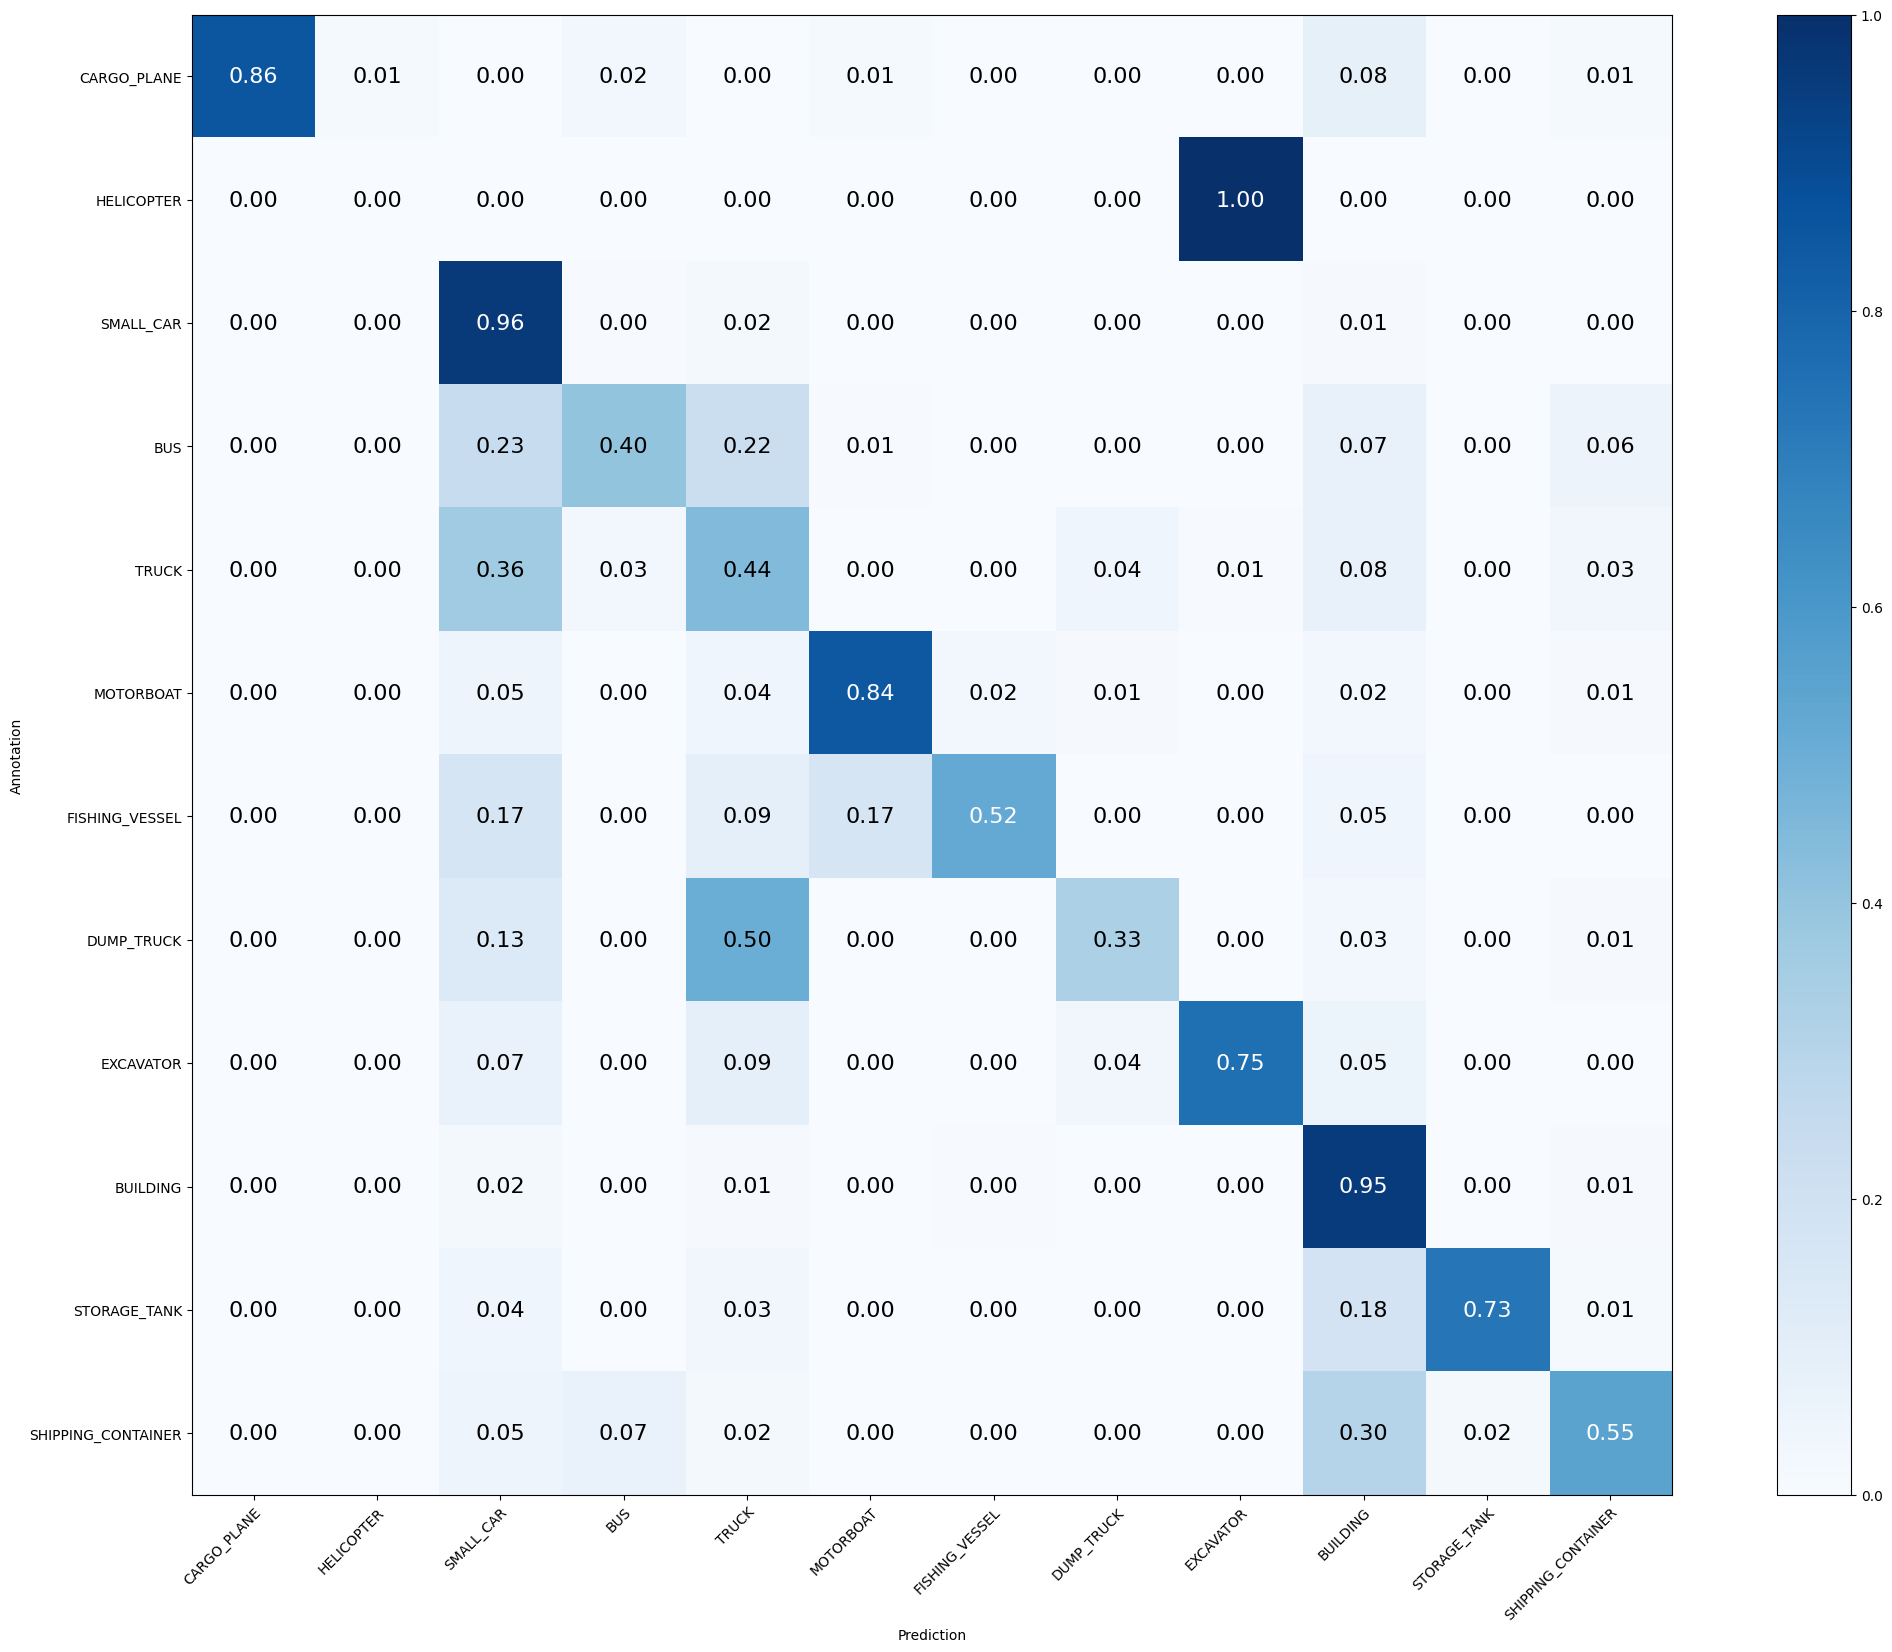

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)


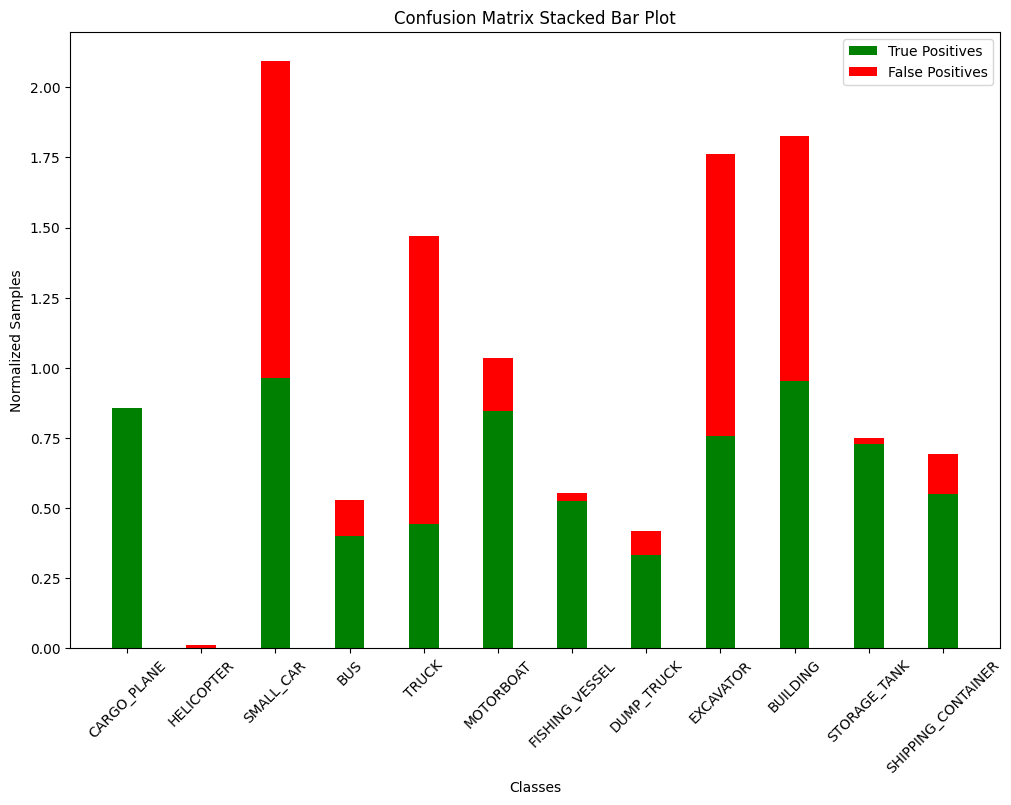

In [ ]:
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))

# Normalize the confusion matrix
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a bar plot
plt.figure(figsize=(12, 8))
bar_width = 0.4
class_labels = list(categories.values())
x = np.arange(len(class_labels))

# Plot the true positive bars
plt.bar(x, np.diag(normalized_cm), width=bar_width, color='g', align='center', label='True Positives')

# Plot the false positive bars (stacked)
false_positives = np.sum(normalized_cm, axis=0) - np.diag(normalized_cm)
plt.bar(x, false_positives, width=bar_width, bottom=np.diag(normalized_cm), color='r', align='center', label='False Positives')

# Set labels and title
plt.xticks(x, class_labels, rotation=45)
plt.xlabel('Classes')
plt.ylabel('Normalized Samples')
plt.title('Confusion Matrix Stacked Bar Plot')
plt.legend()

plt.show()

In [ ]:
import numpy as np


# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 79.004%
Mean Recall: 61.206%
Mean Precision: 69.394%
> CARGO_PLANE: Recall: 85.542% Precision: 97.260% Specificity: 99.957% Dice: 91.026%
> HELICOPTER: Recall: 0.000% Precision: 0.000% Specificity: 99.979% Dice: 0.000%
> SMALL_CAR: Recall: 96.181% Precision: 76.183% Specificity: 87.024% Dice: 85.021%
> BUS: Recall: 40.044% Precision: 83.028% Specificity: 99.145% Dice: 54.030%
> TRUCK: Recall: 44.173% Precision: 57.598% Specificity: 94.463% Dice: 50.000%
> MOTORBOAT: Recall: 84.426% Precision: 85.124% Specificity: 99.613% Dice: 84.774%
> FISHING_VESSEL: Recall: 52.308% Precision: 75.556% Specificity: 99.767% Dice: 61.818%
> DUMP_TRUCK: Recall: 33.036% Precision: 52.857% Specificity: 99.293% Dice: 40.659%
> EXCAVATOR: Recall: 75.439% Precision: 87.755% Specificity: 99.873% Dice: 81.132%
> BUILDING: Recall: 95.408% Precision: 90.104% Specificity: 94.986% Dice: 92.680%
> STORAGE_TANK: Recall: 72.917% Precision: 94.595% Specificity: 99.870% Dice: 82.353%
> SHIPPING_CONTAINER:

In [ ]:
import pandas as pd

# Initialize lists for each metric
recall_list = []
precision_list = []
specificity_list = []
f1_score_list = []

for idx in range(len(categories)):
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))

    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))

    recall_list.append(recall * 100)
    precision_list.append(precision * 100)
    specificity_list.append(specificity * 100)
    f1_score_list.append(f1_score * 100)

# Create a dictionary with the data
data = {
    "Object Category": list(categories.values()),
    "Recall": recall_list,
    "Precision": precision_list,
    "Specificity": specificity_list,
    "Dice": f1_score_list,
}

# Create the pandas DataFrame
df = pd.DataFrame(data)
print(df)


       Object Category     Recall  Precision  Specificity       Dice
0          CARGO_PLANE  85.542169  97.260274    99.957392  91.025641
1           HELICOPTER   0.000000   0.000000    99.979062   0.000000
2            SMALL_CAR  96.180556  76.182618    87.024273  85.021486
3                  BUS  40.044248  83.027523    99.144509  54.029851
4                TRUCK  44.172662  57.598499    94.463498  50.000000
5            MOTORBOAT  84.426230  85.123967    99.613319  84.773663
6       FISHING_VESSEL  52.307692  75.555556    99.766553  61.818182
7           DUMP_TRUCK  33.035714  52.857143    99.292605  40.659341
8            EXCAVATOR  75.438596  87.755102    99.872881  81.132075
9             BUILDING  95.407503  90.103849    94.986072  92.679862
10        STORAGE_TANK  72.916667  94.594595    99.870494  82.352941
11  SHIPPING_CONTAINER  55.000000  32.673267    98.558406  40.993789


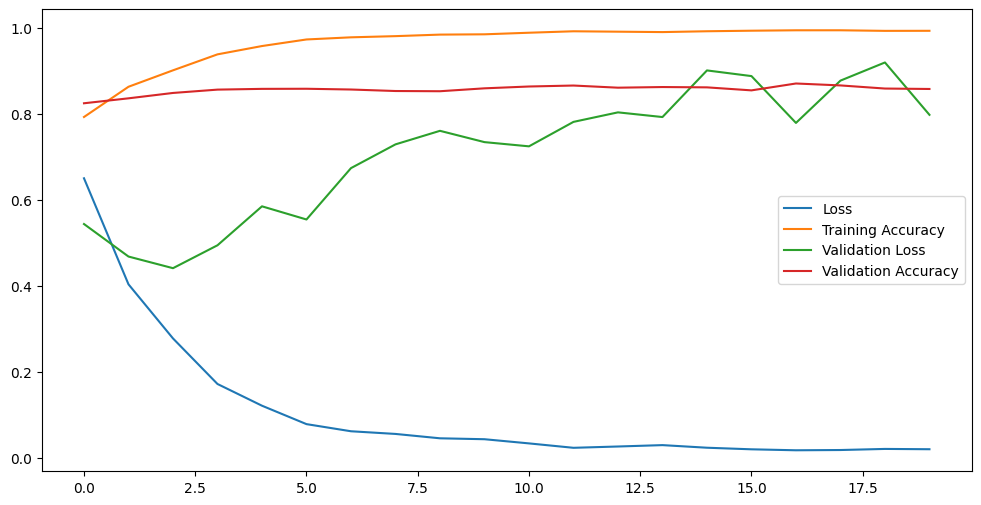

In [ ]:


plt.figure(figsize=(12, 6))

plt.plot(h.history['loss'], label='Loss')
plt.plot(h.history['accuracy'], label='Training Accuracy')
plt.plot(h.history['val_loss'], label='Validation Loss')
plt.plot(h.history['val_accuracy'], label='Validation Accuracy')

plt.legend()
plt.show()